In [1]:
import os
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

In [2]:
JOBLIB_PATH = r"D:\CAPSTONE DESIGN\PP002\binary_dataset.joblib"  # <-- your path (raw string)
RANDOM_STATE = 42
LATENT_DIM = 32
AE_EPOCHS = 100
AE_BATCH = 256                 # big batches for speed if GPU available; reduce if OOM
AE_SAVE_PATH = "ae_001.keras"
ENCODER_SAVE_DIR = "encoder_model"
LATENT_FEATURES_PATH = "latent_features.joblib"
CLASSIFIER_SAVE_PATH = "classifier.joblib"
SCALER_PATH = "scaler.joblib"
CLASSIFIER_SAMPLE_SIZE = 200_000   # set to None to use full latent train set (may be heavy)
USE_RANDOM_FOREST = True 

In [3]:
# ---- 1) Load & inspect joblib ----
obj = joblib.load(JOBLIB_PATH)
print("Loaded object type:", type(obj))

# helper inspect
def inspect_obj(o):
    if isinstance(o, dict):
        print("Dict keys:", list(o.keys()))
        for k in o:
            v = o[k]
            print(f" - key: {k} -> type {type(v)}, shape/len:", getattr(v, "shape", None) or len(v) if hasattr(v, "__len__") else None)
    elif isinstance(o, (pd.DataFrame, pd.Series)):
        print("Pandas object shape:", o.shape)
        print("Columns sample:", o.columns[:20])
    elif hasattr(o, "shape"):
        print("Has shape:", o.shape)
    else:
        try:
            print("len:", len(o))
        except:
            print("Cannot determine shape/len")

inspect_obj(obj)

Loaded object type: <class 'dict'>
Dict keys: ['X_train', 'y_train', 'X_val', 'y_val', 'X_test', 'y_test', 'features']
 - key: X_train -> type <class 'pandas.core.frame.DataFrame'>, shape/len: (1764525, 43)
 - key: y_train -> type <class 'pandas.core.series.Series'>, shape/len: (1764525,)
 - key: X_val -> type <class 'pandas.core.frame.DataFrame'>, shape/len: (378113, 43)
 - key: y_val -> type <class 'pandas.core.series.Series'>, shape/len: (378113,)
 - key: X_test -> type <class 'pandas.core.frame.DataFrame'>, shape/len: (378113, 43)
 - key: y_test -> type <class 'pandas.core.series.Series'>, shape/len: (378113,)
 - key: features -> type <class 'list'>, shape/len: 43


In [4]:
# 1) Load joblib
data = joblib.load(JOBLIB_PATH)
print("Loaded keys:", list(data.keys()))

X_train = data["X_train"]
X_val   = data["X_val"]
X_test  = data["X_test"]
y_train = data["y_train"]
y_val   = data["y_val"]
y_test  = data["y_test"]

print("Shapes:", X_train.shape, X_val.shape, X_test.shape, y_train.shape)

Loaded keys: ['X_train', 'y_train', 'X_val', 'y_val', 'X_test', 'y_test', 'features']
Shapes: (1764525, 43) (378113, 43) (378113, 43) (1764525,)


In [5]:
# 2) Check if features look already scaled (mean approx 0, std approx 1)
def looks_scaled(arr, tol_mean=0.2, tol_std=0.8):
    mean = np.mean(arr, axis=0)
    std  = np.std(arr, axis=0)
    # check fraction of features within tolerances
    mean_ok = np.mean(np.abs(mean) < tol_mean)
    std_ok  = np.mean((std > (1 - tol_std)) & (std < (1 + tol_std)))
    return mean_ok > 0.7 and std_ok > 0.7

scaled_flag = looks_scaled(X_train)
print("Looks already scaled (heuristic)?", scaled_flag)

Looks already scaled (heuristic)? False


In [6]:
import numpy as np
import pandas as pd
import joblib
import time
from sklearn.preprocessing import PowerTransformer, StandardScaler

# --- Helper utils ---
def to_numpy(X):
    if isinstance(X, (pd.DataFrame, pd.Series)):
        return X.values
    return np.asarray(X)

def has_any_negative(X):
    Xn = to_numpy(X)
    return Xn.size > 0 and np.nanmin(Xn) < 0

def signed_log1p_arr(X):
    return np.sign(X) * np.log1p(np.abs(X))

def clip_outliers_by_percentile_np(X_train, X_val, X_test, low_pct=0.1, high_pct=99.0):
    low = np.percentile(X_train, low_pct, axis=0)
    high = np.percentile(X_train, high_pct, axis=0)
    def clip_X(X):
        return np.clip(X, low, high)
    return clip_X(X_train), clip_X(X_val), clip_X(X_test), low, high

# -------------------------------------------------------------------
# MAIN PIPELINE WITH CLEAR TERMINAL OUTPUT
# -------------------------------------------------------------------
def preprocess_full_pipeline(
    X_train, X_val, X_test,
    clip_low_pct=0.1, clip_high_pct=99.0,
    use_signed_log_if_neg=True,
    pt_path="power_transformer.joblib",
    scaler_path="standard_scaler.joblib"
):
    print("\n========================================")
    print("🚀 STARTING FULL PREPROCESSING PIPELINE")
    print("========================================\n")

    total_start = time.perf_counter()

    # detect DF vs numpy
    is_df = isinstance(X_train, pd.DataFrame)
    feat_cols = list(X_train.columns) if is_df else [f"f{i}" for i in range(X_train.shape[1])]

    # Convert ke numpy
    Xtr = to_numpy(X_train).astype(float)
    Xv  = to_numpy(X_val).astype(float)
    Xt  = to_numpy(X_test).astype(float)

    print(f"[INFO] Train shape: {Xtr.shape}, Val: {Xv.shape}, Test: {Xt.shape}")
    print(f"[INFO] Negative values exist? {has_any_negative(Xtr) or has_any_negative(Xv) or has_any_negative(Xt)}")

    # -------------------------------------------------------------------
    # 1) LOG transform
    # -------------------------------------------------------------------
    t0 = time.perf_counter()
    if use_signed_log_if_neg and (np.nanmin(Xtr) < 0 or np.nanmin(Xv) < 0 or np.nanmin(Xt) < 0):
        Xtr_t = signed_log1p_arr(Xtr)
        Xv_t  = signed_log1p_arr(Xv)
        Xt_t  = signed_log1p_arr(Xt)
        print("[STEP] Using signed_log1p transform (negative detected).")
    else:
        Xtr_t = np.log1p(Xtr)
        Xv_t  = np.log1p(Xv)
        Xt_t  = np.log1p(Xt)
        print("[STEP] Using np.log1p transform (all non-negative).")
    print(f"[DONE] log transform in {time.perf_counter() - t0:.5f} sec\n")

    # -------------------------------------------------------------------
    # 2) CLIP OUTLIERS
    # -------------------------------------------------------------------
    t0 = time.perf_counter()
    Xtr_c, Xv_c, Xt_c, clip_low, clip_high = clip_outliers_by_percentile_np(
        Xtr_t, Xv_t, Xt_t, low_pct=clip_low_pct, high_pct=clip_high_pct
    )
    print(f"[STEP] Clipping outliers {clip_low_pct}/{clip_high_pct} percentiles.")
    print(f"[INFO] clip_low[0:5]:  {clip_low[:5]}")
    print(f"[INFO] clip_high[0:5]: {clip_high[:5]}")
    print(f"[DONE] clipping in {time.perf_counter() - t0:.5f} sec\n")

    # -------------------------------------------------------------------
    # 3) PowerTransformer (Yeo-Johnson)
    # -------------------------------------------------------------------
    t0 = time.perf_counter()
    col_var = Xtr_c.var(axis=0)
    const_mask = col_var == 0
    nonconst_idx = np.where(~const_mask)[0]

    Xtr_pt = Xtr_c.copy()
    Xv_pt  = Xv_c.copy()
    Xt_pt  = Xt_c.copy()

    if nonconst_idx.size == 0:
        print("[STEP] All features constant → skipping PowerTransformer.")
        pt = None
    else:
        pt = PowerTransformer(method="yeo-johnson", standardize=False)
        pt.fit(Xtr_c[:, nonconst_idx])
        Xtr_pt[:, nonconst_idx] = pt.transform(Xtr_c[:, nonconst_idx])
        Xv_pt[:, nonconst_idx]  = pt.transform(Xv_c[:, nonconst_idx])
        Xt_pt[:, nonconst_idx]  = pt.transform(Xt_c[:, nonconst_idx])
        print(f"[STEP] Applied PowerTransformer on {nonconst_idx.size} features.")
    print(f"[DONE] power-transform in {time.perf_counter() - t0:.5f} sec\n")

    # -------------------------------------------------------------------
    # 4) StandardScaler
    # -------------------------------------------------------------------
    t0 = time.perf_counter()
    scaler = StandardScaler()
    scaler.fit(Xtr_pt)
    Xtr_s = scaler.transform(Xtr_pt).astype(np.float32)
    Xv_s  = scaler.transform(Xv_pt).astype(np.float32)
    Xt_s  = scaler.transform(Xt_pt).astype(np.float32)
    print("[STEP] StandardScaler applied to train/val/test.")
    print(f"[DONE] scaling in {time.perf_counter() - t0:.5f} sec\n")

    # -------------------------------------------------------------------
    # 5) Save transformers
    # -------------------------------------------------------------------
    if pt is not None:
        joblib.dump(pt, pt_path)
        print(f"[SAVE] PowerTransformer saved -> {pt_path}")
    else:
        print("[SAVE] PowerTransformer skipped (no file written).")

    joblib.dump(scaler, scaler_path)
    print(f"[SAVE] StandardScaler saved -> {scaler_path}\n")

    # -------------------------------------------------------------------
    # FINISH
    # -------------------------------------------------------------------
    total_time = time.perf_counter() - total_start
    print("========================================")
    print(f"✅ PIPELINE COMPLETED in {total_time:.5f} seconds")
    print("========================================\n")

    return {
        "X_train_scaled": Xtr_s,
        "X_val_scaled": Xv_s,
        "X_test_scaled": Xt_s,
        "scaler": scaler,
        "power_transformer": pt,
        "clip_low": clip_low,
        "clip_high": clip_high,
    }


In [7]:
out = preprocess_full_pipeline(X_train, X_val, X_test)



🚀 STARTING FULL PREPROCESSING PIPELINE

[INFO] Train shape: (1764525, 43), Val: (378113, 43), Test: (378113, 43)
[INFO] Negative values exist? True
[STEP] Using signed_log1p transform (negative detected).
[DONE] log transform in 1.99348 sec

[STEP] Clipping outliers 0.1/99.0 percentiles.
[INFO] clip_low[0:5]:  [-0.69314718  2.63905733 -0.69314718 -0.69314718  0.        ]
[INFO] clip_high[0:5]: [11.09035489 11.0335016  10.75194902 13.59990492 17.94586557]
[DONE] clipping in 4.32313 sec

[STEP] Applied PowerTransformer on 43 features.
[DONE] power-transform in 82.17095 sec

[STEP] StandardScaler applied to train/val/test.
[DONE] scaling in 1.11586 sec

[SAVE] PowerTransformer saved -> power_transformer.joblib
[SAVE] StandardScaler saved -> standard_scaler.joblib

✅ PIPELINE COMPLETED in 89.94936 seconds



In [8]:
# Ambil data hasil preprocessing
X_train_s = out["X_train_scaled"]   # numpy array hasil scaling
X_val_s   = out["X_val_scaled"]
X_test_s  = out["X_test_scaled"]

# Tentukan label benign
BENIGN_LABEL = 0   # ganti kalau benign kamu bukan 0

# Filter hanya benign
X_train_benign = X_train_s[y_train == BENIGN_LABEL]

print("Benign-only training data shape:", X_train_benign.shape)
print("Jumlah benign:", X_train_benign.shape[0])
print("Jumlah fitur:", X_train_benign.shape[1])


Benign-only training data shape: (1466539, 43)
Jumlah benign: 1466539
Jumlah fitur: 43


In [9]:
# ---------------------------
# Build & train Autoencoder
# Dihubungkan ke pipeline: out["X_train_scaled"], y_train
# ---------------------------

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split

# --- HYPERPARAMS (sesuaikan jika perlu) ---
LATENT_DIM = 32
NOISE_STD = 0.05
L1_REG = 1e-5
BATCH_SIZE = 256
EPOCHS = 100
RANDOM_STATE = 42

# paths (ubah sesuai kebutuhan)
AE_SAVE_PATH = "autoencoder_best.keras"
ENCODER_SAVE_PATH = "encoder_best.keras"
DECODER_SAVE_PATH = "decoder_best.keras"

# --- Prepare benign-only data (assumes out, y_train exist) ---
X_train_s = out["X_train_scaled"]    # numpy array float32
BENIGN_LABEL = 0                     # ganti kalau label benign-mu bukan 0

# filter benign only
X_benign = X_train_s[y_train == BENIGN_LABEL]
print("Benign-only shape:", X_benign.shape)

# split into train/val for AE training
X_ae_train, X_ae_val = train_test_split(
    X_benign, test_size=0.1, random_state=RANDOM_STATE, shuffle=True
)
print("AE train shape:", X_ae_train.shape, "AE val shape:", X_ae_val.shape)

# ensure dtype float32
X_ae_train = X_ae_train.astype("float32")
X_ae_val   = X_ae_val.astype("float32")

input_dim = X_ae_train.shape[1]
print("AE input dim:", input_dim)

# --- Autoencoder builder (dense) ---
def build_dense_autoencoder(input_dim, latent_dim=32, noise_std=0.05, l1_reg=1e-5):
    inp = layers.Input(shape=(input_dim,), name="ae_input")
    x = layers.GaussianNoise(noise_std)(inp)
    x = layers.Dense(128, activation="relu", name="enc_dense1")(x)
    x = layers.BatchNormalization(name="enc_bn1")(x)
    x = layers.Dense(64, activation="relu", name="enc_dense2")(x)
    x = layers.BatchNormalization(name="enc_bn2")(x)
    latent = layers.Dense(latent_dim, activation=None, name="latent",
                        activity_regularizer=tf.keras.regularizers.l1(l1_reg))(x)

    # decoder model
    latent_in = layers.Input(shape=(latent_dim,), name="z_input")
    d = layers.Dense(64, activation="relu", name="dec_dense1")(latent_in)
    d = layers.BatchNormalization(name="dec_bn1")(d)
    d = layers.Dense(128, activation="relu", name="dec_dense2")(d)
    d = layers.BatchNormalization(name="dec_bn2")(d)
    dec_out = layers.Dense(input_dim, activation=None, name="dec_output")(d)
    decoder = models.Model(latent_in, dec_out, name="decoder")

    # encoder & autoencoder
    recon = decoder(latent)
    auto = models.Model(inputs=inp, outputs=recon, name="autoencoder")
    encoder = models.Model(inputs=inp, outputs=latent, name="encoder")
    return auto, encoder, decoder

# build models
autoencoder, encoder, decoder = build_dense_autoencoder(input_dim, LATENT_DIM, NOISE_STD, L1_REG)

# compile
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss="mse")
autoencoder.summary()

# callbacks
es = callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True, verbose=1)
mc = callbacks.ModelCheckpoint(AE_SAVE_PATH, monitor="val_loss", save_best_only=True, verbose=1)
# optional: save encoder/decoder after best AE saved
save_encoder_cb = callbacks.LambdaCallback(
    on_epoch_end=lambda epoch, logs: (encoder.save(ENCODER_SAVE_PATH) if epoch==0 else None)
)

# --- Prepare tf.data datasets for efficient training ---
train_ds = tf.data.Dataset.from_tensor_slices((X_ae_train, X_ae_train))
train_ds = train_ds.shuffle(buffer_size=len(X_ae_train), seed=RANDOM_STATE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_ae_val, X_ae_val))
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# --- Fit the autoencoder ---
history = autoencoder.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[es, mc],
    verbose=2
)

# --- After training: save encoder & decoder (best weights already restored by EarlyStopping if used) ---
encoder.save(ENCODER_SAVE_PATH)
decoder.save(DECODER_SAVE_PATH)
print(f"Saved autoencoder -> {AE_SAVE_PATH}")
print(f"Saved encoder -> {ENCODER_SAVE_PATH}")
print(f"Saved decoder -> {DECODER_SAVE_PATH}")

# --- Return what might be useful ---
# history.history contains loss/val_loss per epoch
ae_artifacts = {
    "autoencoder": autoencoder,
    "encoder": encoder,
    "decoder": decoder,
    "history": history,
    "AE_SAVE_PATH": AE_SAVE_PATH,
    "ENCODER_SAVE_PATH": ENCODER_SAVE_PATH,
    "DECODER_SAVE_PATH": DECODER_SAVE_PATH
}


Benign-only shape: (1466539, 43)
AE train shape: (1319885, 43) AE val shape: (146654, 43)
AE input dim: 43


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ae_input (InputLayer)           │ (None, 43)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise (GaussianNoise)  │ (None, 43)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dense1 (Dense)              │ (None, 128)            │         5,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_bn1 (BatchNormalization)    │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dense2 (Dense)              │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_bn2 (BatchNormalization)    │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 43)             │        16,747 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,483 (130.79 KB)

 Trainable params: 32,715 (127.79 KB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/100

Epoch 1: val_loss improved from inf to 0.01237, saving model to autoencoder_best.keras
5156/5156 - 20s - 4ms/step - loss: 0.0359 - val_loss: 0.0124
Epoch 2/100

Epoch 2: val_loss did not improve from 0.01237
5156/5156 - 41s - 8ms/step - loss: 0.0135 - val_loss: 0.0157
Epoch 3/100

Epoch 3: val_loss improved from 0.01237 to 0.00728, saving model to autoencoder_best.keras
5156/5156 - 51s - 10ms/step - loss: 0.0112 - val_loss: 0.0073
Epoch 4/100

Epoch 4: val_loss improved from 0.00728 to 0.00685, saving model to autoencoder_best.keras
5156/5156 - 58s - 11ms/step - loss: 0.0100 - val_loss: 0.0068
Epoch 5/100

Epoch 5: val_loss improved from 0.00685 to 0.00646, saving model to autoencoder_best.keras
5156/5156 - 61s - 12ms/step - loss: 0.0094 - val_loss: 0.0065
Epoch 6/100

Epoch 6: val_loss did not improve from 0.00646
5156/5156 - 75s - 14ms/step - loss: 0.0088 - val_loss: 0.0068
Epoch 7/100

Epoch 7: val_loss improved from 0.00646 to 0.00484, saving model to autoencoder_best.

In [10]:
# ----------------------------------------
# Autoencoder Evaluation (Threshold-based)
# ----------------------------------------

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)
import numpy as np

# ----- Helper: reconstruction error -----
def reconstruction_error(ae_model, X, batch_size=256):
    X = np.asarray(X).astype("float32")
    X_hat = ae_model.predict(X, batch_size=batch_size, verbose=0)
    return np.mean(np.square(X - X_hat), axis=1)

# ----- Compute reconstruction error -----
print("[INFO] Computing reconstruction error ...")

recon_train = reconstruction_error(autoencoder, out["X_train_scaled"])
recon_test  = reconstruction_error(autoencoder, out["X_test_scaled"])

y_train_np = np.asarray(y_train)
y_test_np  = np.asarray(y_test)

# ----- Threshold selection (Youden Index from TRAIN set) -----
fpr, tpr, thresholds = roc_curve(y_train_np, recon_train)
youden_index = tpr - fpr
best_idx = np.argmax(youden_index)
threshold = thresholds[best_idx]

print(f"[INFO] Selected threshold (Youden): {threshold:.6f}")

# ----- Prediction -----
y_pred_test = (recon_test > threshold).astype(int)

# ----- Metrics -----
acc  = accuracy_score(y_test_np, y_pred_test)
prec = precision_score(y_test_np, y_pred_test)
rec  = recall_score(y_test_np, y_pred_test)
f1   = f1_score(y_test_np, y_pred_test)
auc  = roc_auc_score(y_test_np, recon_test)

print("\n=== AUTOENCODER EVALUATION (TEST SET) ===")
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1-score  : {f1:.4f}")
print(f"ROC-AUC   : {auc:.4f}")

print("\n[CONFUSION MATRIX]")
print(confusion_matrix(y_test_np, y_pred_test))

print("\n[CLASSIFICATION REPORT]")
print(classification_report(y_test_np, y_pred_test, digits=4))


[INFO] Computing reconstruction error ...
[INFO] Selected threshold (Youden): 0.002424

=== AUTOENCODER EVALUATION (TEST SET) ===
Accuracy  : 0.9276
Precision : 0.7703
Recall    : 0.8139
F1-score  : 0.7915
ROC-AUC   : 0.9450

[CONFUSION MATRIX]
[[298759  15500]
 [ 11886  51968]]

[CLASSIFICATION REPORT]
              precision    recall  f1-score   support

           0     0.9617    0.9507    0.9562    314259
           1     0.7703    0.8139    0.7915     63854

    accuracy                         0.9276    378113
   macro avg     0.8660    0.8823    0.8738    378113
weighted avg     0.9294    0.9276    0.9284    378113



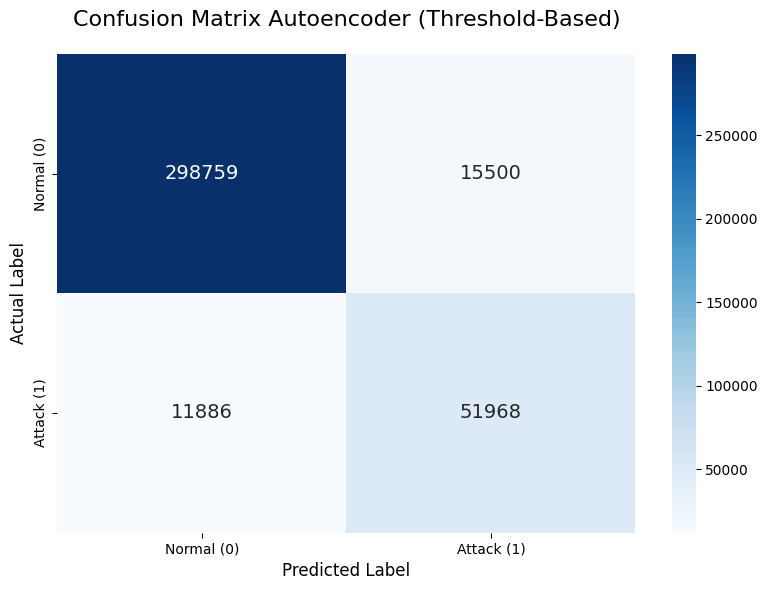

In [11]:
# ----------------------------------------
# Plot Confusion Matrix (Heatmap)
# ----------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=True,
        xticklabels=["Normal (0)", "Attack (1)"],
        yticklabels=["Normal (0)", "Attack (1)"],
        annot_kws={"size": 14}
    )

    plt.title(title, fontsize=16, pad=20)
    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("Actual Label", fontsize=12)
    plt.tight_layout()
    plt.show()

# ----- Call plot -----
plot_confusion_matrix(
    y_test_np,
    y_pred_test,
    title="Confusion Matrix Autoencoder (Threshold-Based)"
)


In [27]:
# ----------------------------------------
# Extract latent features -> train binary NN classifier
# ----------------------------------------
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# ----- CONFIG -----
LATENT_BATCH = 256
CLF_BATCH = 128
CLF_EPOCHS = 100
CLF_SAVE_PATH = "classifier_best.keras"
RANDOM_STATE = 42

# ----- HELPER: ensure arrays and shapes -----
# expects `out` from preprocess_full_pipeline and `encoder` from AE
if "out" not in globals():
    raise RuntimeError("Variable `out` (pipeline output) not found. Run preprocess_full_pipeline first.")

X_train_scaled = out["X_train_scaled"]
X_val_scaled   = out.get("X_val_scaled", None)
X_test_scaled  = out.get("X_test_scaled", None)

# check labels
if "y_train" not in globals():
    raise RuntimeError("`y_train` not found in global namespace. Provide labels for training samples.")
y_train = np.asarray(y_train)

# If y_val exists use it, else create validation split from training labels/features
if "y_val" in globals() and y_val is not None:
    y_val = np.asarray(y_val)
else:
    # create a validation split from X_train_scaled for classifier training (stratified)
    print("[INFO] y_val not found -> creating validation split from training set for classifier.")
    X_train_scaled, X_val_scaled_tmp, y_train, y_val = train_test_split(
        X_train_scaled, y_train, test_size=0.1, random_state=RANDOM_STATE, stratify=y_train
    )
    # keep X_val_scaled if pipeline provided separate X_val_scaled: we won't overwrite it; classifier uses split above
    X_val_scaled = X_val_scaled_tmp

# For test labels - optional but recommended
y_test = np.asarray(y_test) if "y_test" in globals() else None
if X_test_scaled is None:
    print("[WARN] X_test_scaled not available in `out`. Skipping final test evaluation unless you provide test set.")
if y_test is None:
    print("[WARN] y_test not provided. Final evaluation on test set will be skipped.")

print(f"[INFO] Classifier train shape: {X_train_scaled.shape}, val shape: {X_val_scaled.shape}, test shape: {None if X_test_scaled is None else X_test_scaled.shape}")
print(f"[INFO] y_train distribution: {np.unique(y_train, return_counts=True)}")

# ----- Extract latent features using encoder -----
# If encoder variable not present (e.g., new session), try to load from file if path exists
try:
    enc = encoder
except NameError:
    import os
    if os.path.exists("encoder_best.h5"):
        enc = tf.keras.models.load_model("encoder_best.h5")
        print("[INFO] Loaded encoder from encoder_best.h5")
    else:
        raise RuntimeError("`encoder` not found and encoder_best.h5 not present. Provide encoder model.")

def to_latent(encoder_model, X, batch_size=LATENT_BATCH):
    # Accept numpy arrays or DataFrames
    if hasattr(X, "values"):
        Xn = X.values.astype("float32")
    else:
        Xn = np.asarray(X).astype("float32")
    return encoder_model.predict(Xn, batch_size=batch_size, verbose=0)

print("[INFO] Extracting latent features for train/val/test ...")
Z_train = to_latent(enc, X_train_scaled)
Z_val   = to_latent(enc, X_val_scaled)
Z_test  = to_latent(enc, X_test_scaled) if (X_test_scaled is not None) else None
print("[DONE] Latent shapes ->", Z_train.shape, Z_val.shape, (None if Z_test is None else Z_test.shape))

# ----- Build classifier model (simple MLP on latent) -----
def build_classifier(input_dim, hidden_units=(64,32), dropout=0.3):
    inp = layers.Input(shape=(input_dim,), name="clf_input")
    x = inp
    for i, h in enumerate(hidden_units):
        x = layers.Dense(h, activation="relu", name=f"clf_dense{i+1}")(x)
        x = layers.BatchNormalization(name=f"clf_bn{i+1}")(x)
        x = layers.Dropout(dropout, name=f"clf_drop{i+1}")(x)
    outp = layers.Dense(1, activation="sigmoid", name="clf_out")(x)
    model = models.Model(inp, outp, name="classifier")
    return model



clf = build_classifier(Z_train.shape[1], hidden_units=(128,64), dropout=0.3)
clf.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss="binary_crossentropy",
            metrics=["accuracy", tf.keras.metrics.AUC(name="auc")])
clf.summary()

[INFO] Classifier train shape: (1764525, 43), val shape: (378113, 43), test shape: (378113, 43)
[INFO] y_train distribution: (array([0, 1], dtype=int64), array([1466539,  297986], dtype=int64))
[INFO] Extracting latent features for train/val/test ...
[DONE] Latent shapes -> (1764525, 32) (378113, 32) (378113, 32)


Model: "classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ clf_input (InputLayer)          │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ clf_dense1 (Dense)              │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ clf_bn1 (BatchNormalization)    │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ clf_drop1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ clf_dense2 (Dense)              │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ clf_bn2 (BatchNormalization)    │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ clf_drop2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ clf_out (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,313 (52.00 KB)

 Trainable params: 12,929 (50.50 KB)

 Non-trainable params: 384 (1.50 KB)

In [31]:
# ----- Compute class weights (help with imbalance) -----
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight_dict = {c: w for c, w in zip(classes, class_weights)}
print("[INFO] Computed class weights:", class_weight_dict)

# ----- Callbacks -----
es = callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=10, restore_best_weights=True, verbose=1)
mc = callbacks.ModelCheckpoint(CLF_SAVE_PATH, monitor="val_auc", mode="max", save_best_only=True, verbose=1)

# ----- Prepare tf.data datasets (optional) -----
train_ds = tf.data.Dataset.from_tensor_slices((Z_train, y_train)).shuffle(len(Z_train), seed=RANDOM_STATE).batch(CLF_BATCH).prefetch(tf.data.AUTOTUNE)
val_ds   = tf.data.Dataset.from_tensor_slices((Z_val, y_val)).batch(CLF_BATCH).prefetch(tf.data.AUTOTUNE)

# ----- Train classifier -----
history_clf = clf.fit(
    train_ds,
    validation_data=val_ds,
    epochs=CLF_EPOCHS,
    class_weight=class_weight_dict,
    callbacks=[es, mc],
    verbose=2
)


[INFO] Computed class weights: {0: 0.6015949797448278, 1: 2.9607515118159915}
Epoch 1/100

Epoch 1: val_auc improved from -inf to 0.99951, saving model to classifier_best.keras
13786/13786 - 39s - 3ms/step - accuracy: 0.9899 - auc: 0.9987 - loss: 0.0338 - val_accuracy: 0.9949 - val_auc: 0.9995 - val_loss: 0.0165
Epoch 2/100

Epoch 2: val_auc improved from 0.99951 to 0.99959, saving model to classifier_best.keras
13786/13786 - 62s - 4ms/step - accuracy: 0.9942 - auc: 0.9993 - loss: 0.0212 - val_accuracy: 0.9963 - val_auc: 0.9996 - val_loss: 0.0141
Epoch 3/100

Epoch 3: val_auc improved from 0.99959 to 0.99962, saving model to classifier_best.keras
13786/13786 - 38s - 3ms/step - accuracy: 0.9948 - auc: 0.9993 - loss: 0.0192 - val_accuracy: 0.9974 - val_auc: 0.9996 - val_loss: 0.0125
Epoch 4/100

Epoch 4: val_auc did not improve from 0.99962
13786/13786 - 56s - 4ms/step - accuracy: 0.9952 - auc: 0.9994 - loss: 0.0174 - val_accuracy: 0.9942 - val_auc: 0.9996 - val_loss: 0.0143
Epoch 5/100


In [32]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_curve, classification_report, confusion_matrix

# ----- LOAD MODELS -----
ENCODER_PATH = "encoder_best.keras"
CLF_PATH = "classifier_best.keras"

encoder = tf.keras.models.load_model(ENCODER_PATH)
classifier = tf.keras.models.load_model(CLF_PATH)

print("Models loaded.")

# ----- PREPARE VALIDATION DATA -----
# X_val_scaled: output preprocessing (float32)
# y_val: ground truth labels

X_val_scaled = X_val_scaled.astype("float32")
y_val = np.asarray(y_val)

# ----- EXTRACT LATENT FEATURES -----
Z_val = encoder.predict(X_val_scaled, batch_size=256, verbose=0)

print("Latent validation shape:", Z_val.shape)

# ----- PREDICT PROBABILITIES -----
val_probs = classifier.predict(Z_val, batch_size=256, verbose=0).ravel()

# ----- COMPUTE YOUDEN’S J -----
fpr, tpr, thresholds = roc_curve(y_val, val_probs)
youden_j = tpr - fpr

best_idx = np.argmax(youden_j)
best_threshold = thresholds[best_idx]

print("\n=== YOUDEN RESULT ===")
print("Best threshold :", best_threshold)
print("Youden J       :", youden_j[best_idx])
print("TPR (Recall)   :", tpr[best_idx])
print("FPR            :", fpr[best_idx])

# ----- EVALUATION WITH YOUDEN THRESHOLD -----
val_pred_youden = (val_probs >= best_threshold).astype(int)

print("\n=== Validation Report (Youden Threshold) ===")
print(classification_report(y_val, val_pred_youden, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_val, val_pred_youden))


Models loaded.
Latent validation shape: (378113, 32)

=== YOUDEN RESULT ===
Best threshold : 0.43907404
Youden J       : 0.9937734875589438
TPR (Recall)   : 0.9973533373007173
FPR            : 0.0035798497417735054

=== Validation Report (Youden Threshold) ===
              precision    recall  f1-score   support

           0     0.9995    0.9964    0.9979    314259
           1     0.9826    0.9974    0.9899     63854

    accuracy                         0.9966    378113
   macro avg     0.9911    0.9969    0.9939    378113
weighted avg     0.9966    0.9966    0.9966    378113

Confusion Matrix:
 [[313134   1125]
 [   169  63685]]


In [33]:
for th in [0.2, 0.3, 0.4, 0.5]:
    preds = (val_probs >= th).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_val, preds).ravel()
    print(f"\nThreshold {th}")
    print(f"TPR (Recall): {tp/(tp+fn):.4f}")
    print(f"FPR: {fp/(fp+tn):.4f}")



Threshold 0.2
TPR (Recall): 0.9978
FPR: 0.0052

Threshold 0.3
TPR (Recall): 0.9976
FPR: 0.0044

Threshold 0.4
TPR (Recall): 0.9974
FPR: 0.0038

Threshold 0.5
TPR (Recall): 0.9970
FPR: 0.0034


In [34]:
# ----- Evaluate on validation set (best) -----
val_preds = clf.predict(Z_val, batch_size=CLF_BATCH).ravel()
val_pred_labels = (val_preds >= 0.3).astype(int)
print("\n=== Validation classification report ===")
print(classification_report(y_val, val_pred_labels, digits=4))
print("Validation ROC AUC:", roc_auc_score(y_val, val_preds))
print("Validation confusion matrix:\n", confusion_matrix(y_val, val_pred_labels))

# ----- Evaluate on test set if available -----
if (Z_test is not None) and (y_test is not None):
    test_preds = clf.predict(Z_test, batch_size=CLF_BATCH).ravel()
    test_pred_labels = (test_preds >= 0.3).astype(int)
    print("\n=== Test classification report ===")
    print(classification_report(y_test, test_pred_labels, digits=4))
    print("Test ROC AUC:", roc_auc_score(y_test, test_preds))
    print("Test confusion matrix:\n", confusion_matrix(y_test, test_pred_labels))
else:
    print("\n[INFO] Skipping test evaluation because X_test or y_test is missing.")

# ----- Save final classifier (best is saved by ModelCheckpoint) -----
print(f"\n[INFO] Classifier training finished. Best model saved to: {CLF_SAVE_PATH}")

# ----- Return artifacts -----
clf_artifacts = {
    "classifier": clf,
    "history": history_clf,
    "Z_train": Z_train,
    "Z_val": Z_val,
    "Z_test": Z_test,
    "y_train": y_train,
    "y_val": y_val,
    "y_test": y_test,
    "class_weight": class_weight_dict,
    "CLF_SAVE_PATH": CLF_SAVE_PATH
}

2955/2955 ━━━━━━━━━━━━━━━━━━━━ 2s 518us/step

=== Validation classification report ===
              precision    recall  f1-score   support

           0     0.9995    0.9956    0.9975    314259
           1     0.9786    0.9976    0.9880     63854

    accuracy                         0.9959    378113
   macro avg     0.9891    0.9966    0.9928    378113
weighted avg     0.9960    0.9959    0.9959    378113

Validation ROC AUC: 0.9999091534966795
Validation confusion matrix:
 [[312868   1391]
 [   152  63702]]
2955/2955 ━━━━━━━━━━━━━━━━━━━━ 2s 578us/step

=== Test classification report ===
              precision    recall  f1-score   support

           0     0.9995    0.9958    0.9976    314259
           1     0.9795    0.9977    0.9885     63854

    accuracy                         0.9961    378113
   macro avg     0.9895    0.9967    0.9931    378113
weighted avg     0.9962    0.9961    0.9961    378113

Test ROC AUC: 0.9999045273734556
Test confusion matrix:
 [[312925   1334]


In [35]:
from sklearn.metrics import roc_curve

# --- Compute Youden's J to find best threshold ---
fpr, tpr, thresholds = roc_curve(y_val, val_preds)

youden_j = tpr - fpr
best_idx = np.argmax(youden_j)
best_threshold = thresholds[best_idx]

print("Best threshold (Youden):", best_threshold)
print("Youden J:", youden_j[best_idx])
print("TPR (Recall Attack):", tpr[best_idx])
print("FPR:", fpr[best_idx])


Best threshold (Youden): 0.43907404
Youden J: 0.9937734875589438
TPR (Recall Attack): 0.9973533373007173
FPR: 0.0035798497417735054


In [36]:
val_pred_labels_youden = (val_preds >= best_threshold).astype(int)

print("\n=== Validation report (Youden threshold) ===")
print(classification_report(y_val, val_pred_labels_youden, digits=4))
print("Validation confusion matrix:\n",
    confusion_matrix(y_val, val_pred_labels_youden))



=== Validation report (Youden threshold) ===
              precision    recall  f1-score   support

           0     0.9995    0.9964    0.9979    314259
           1     0.9826    0.9974    0.9899     63854

    accuracy                         0.9966    378113
   macro avg     0.9911    0.9969    0.9939    378113
weighted avg     0.9966    0.9966    0.9966    378113

Validation confusion matrix:
 [[313134   1125]
 [   169  63685]]


In [37]:
test_pred_labels_youden = (test_preds >= best_threshold).astype(int)

print("\n=== Test report (Youden threshold) ===")
print(classification_report(y_test, test_pred_labels_youden, digits=4))
print("Test confusion matrix:\n",
    confusion_matrix(y_test, test_pred_labels_youden))



=== Test report (Youden threshold) ===
              precision    recall  f1-score   support

           0     0.9995    0.9965    0.9980    314259
           1     0.9830    0.9975    0.9902     63854

    accuracy                         0.9967    378113
   macro avg     0.9912    0.9970    0.9941    378113
weighted avg     0.9967    0.9967    0.9967    378113

Test confusion matrix:
 [[313155   1104]
 [   157  63697]]


In [38]:
import tensorflow as tf

INPUT_MODEL = "classifier_best.keras"
OUTPUT_TFLITE = "classifier_fp32.tflite"

# Load classifier
print(f"Loading model: {INPUT_MODEL}")
model = tf.keras.models.load_model(INPUT_MODEL)
print("Model loaded. Input shape:", model.input_shape, "Output shape:", model.output_shape)

# Convert to TFLite float32 (no quantization)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save
with open(OUTPUT_TFLITE, "wb") as f:
    f.write(tflite_model)

print(f"Saved TFLite float32 model -> {OUTPUT_TFLITE}")


Loading model: classifier_best.keras
Model loaded. Input shape: (None, 32) Output shape: (None, 1)
INFO:tensorflow:Assets written to: C:\Users\HP\AppData\Local\Temp\tmpqkfl_3ok\assets


INFO:tensorflow:Assets written to: C:\Users\HP\AppData\Local\Temp\tmpqkfl_3ok\assets


Saved artifact at 'C:\Users\HP\AppData\Local\Temp\tmpqkfl_3ok'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32), dtype=tf.float32, name='clf_input')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2342140450320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2342140453200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2342140452432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2342140452816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2342140452048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2342140449360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2342140451472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2342140453584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2342140453776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2342140451088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2342140448592: Tenso

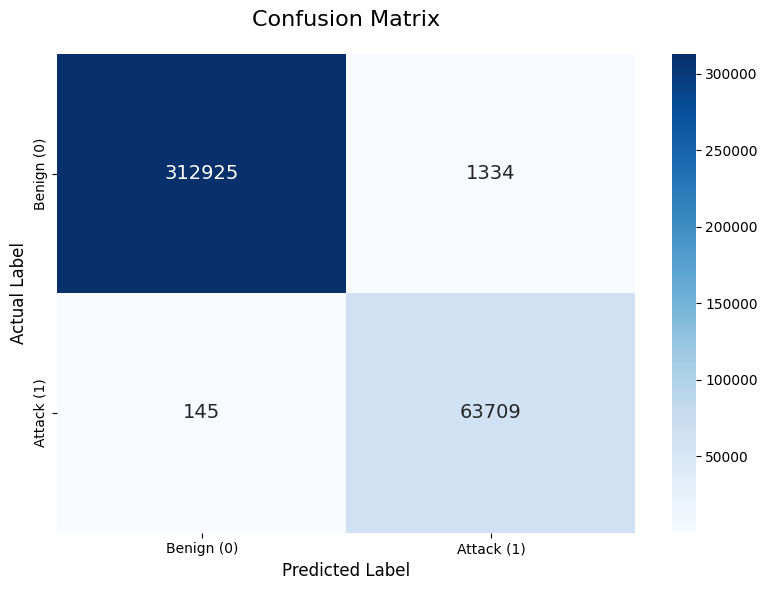

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=True,
        xticklabels=["Benign (0)", "Attack (1)"],
        yticklabels=["Benign (0)", "Attack (1)"],
        annot_kws={"size": 14}
    )

    plt.title(title, fontsize=16, pad=20)
    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("Actual Label", fontsize=12)
    plt.tight_layout()
    plt.show()

if y_test is not None:
    plot_confusion_matrix(
        y_test,
        test_pred_labels,
        title="Confusion Matrix"
    )



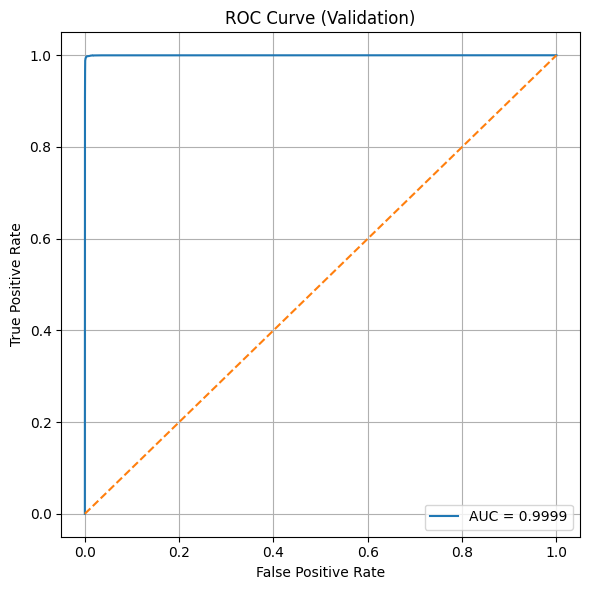

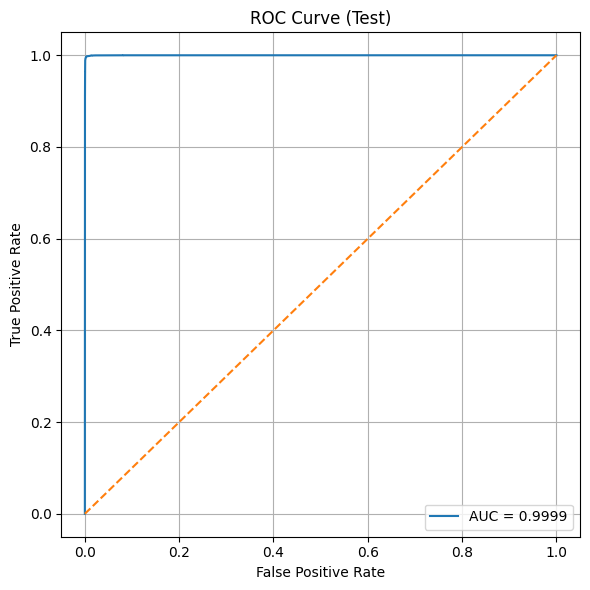

In [53]:
from sklearn.metrics import roc_curve, auc

def plot_roc(y_true, y_score, title):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
plot_roc(
    y_val,
    val_preds,
    title="ROC Curve (Validation)"
)
if y_test is not None:
    plot_roc(
        y_test,
        test_preds,
        title="ROC Curve (Test)"
    )



In [50]:
def plot_train_val_loss(history, title="Training History"):
    loss = history.history.get("loss")
    val_loss = history.history.get("val_loss")

    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(7, 5))
    plt.plot(epochs, loss, label="Train Loss")
    if val_loss is not None:
        plt.plot(epochs, val_loss, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


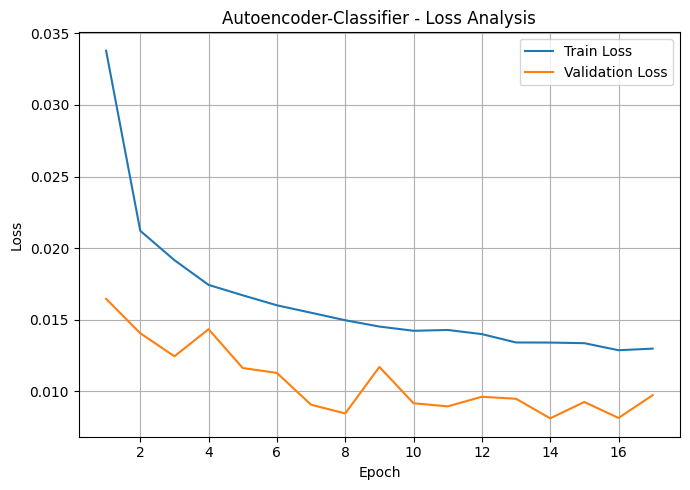

In [58]:
plot_train_val_loss(
    history_clf,
    title="Autoencoder-Classifier - Loss Analysis"
)
